# Text Preparation

In [1]:
import nltk
from nltk.corpus import brown
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
len(brown.sents())

57340

In [3]:
def prepare_brown_data(min_freq: int = 3):
    """
    Returns:
      X: List[np.ndarray] of word indices
      Y: List[np.ndarray] of tag indices (gold, for supervised)
      word2idx, idx2word, tag2idx, idx2tag
    """


    nltk.download("brown", quiet=True)
    nltk.download("universal_tagset", quiet=True)

    tagged_sents = brown.tagged_sents(tagset="universal")

    # vocab with <UNK>
    words = [w.lower() for sent in tagged_sents for (w, _) in sent]
    freqs = Counter(words)
    vocab = ["<UNK>", "<PAD>"] + [w for w, c in freqs.items() if c >= min_freq]
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}

    # tags (fixed small set)
    tags = sorted({t for sent in tagged_sents for (_, t) in sent})
    tag2idx = {t: i for i, t in enumerate(tags)}
    idx2tag = {i: t for t, i in tag2idx.items()}

    X, Y = [], []
    for sent in tagged_sents:
        ws, ts = zip(*sent)
        x = np.array([word2idx.get(w.lower(), 0) for w in ws], dtype=np.int32)
        y = np.array([tag2idx[t] for t in ts], dtype=np.int32)
        X.append(x)
        Y.append(y)

    # print(f"Vocab size: {len(vocab)}, #Tags: {len(tags)}, #Sentences: {len(X)}")
    return X, Y, word2idx, idx2word, tag2idx, idx2tag

In [4]:
def get_training_data():
    X, Y, word2idx, idx2word, tag2idx, idx2tag = prepare_brown_data(min_freq=1)
    # Split into train/dev
    X_train, X_dev, Y_train, Y_dev = train_test_split(
        X, Y, test_size=0.1, random_state=42, shuffle=True
    )
    return X_train, Y_train, X_dev, Y_dev, word2idx, idx2word, tag2idx, idx2tag

In [5]:
X_train, Y_train, X_dev, Y_dev, word2idx, idx2word, tag2idx, idx2tag = get_training_data()

In [6]:
word2idx.get('<PAD>'), idx2word.get(0)

(1, '<UNK>')

# Model

In [7]:
import torch
import torch.nn as nn

In [8]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Linear(input_dim + hidden_dim, 4 * hidden_dim)

    def forward(self, x):
        if x.ndim != 3:
            raise ValueError("Expected input shape (batch_size, seq_len, input_dim)")

        batch_size, seq_len, _ = x.size()
        device = x.device

        h_t = torch.zeros(batch_size, self.hidden_dim, device=device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=device)

        all_ht = []

        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch_size, input_dim)
            combined = torch.cat((x_t, h_t), dim=1)  # (batch_size, input_dim + hidden_dim)

            gates = self.W(combined)
            i_t, f_t, g_t, o_t = torch.chunk(gates, 4, dim=1)

            i_t = torch.sigmoid(i_t)
            f_t = torch.sigmoid(f_t)
            g_t = torch.tanh(g_t)
            o_t = torch.sigmoid(o_t)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            all_ht.append(h_t)

        outputs = torch.stack(all_ht, dim=1)

        return outputs


In [9]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()

    self.encoder = LSTM(input_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, hidden_dim)

  def forward(self, x):
    
    x = self.encoder(x)
    x = self.fc(x)


    return x

In [10]:
class Decoder(nn.Module):
  def __init__(self, hidden_dim, output_dim):
    super().__init__()

    self.decoder = LSTM(hidden_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.decoder(x)
    x = self.fc(x)

    return x

In [11]:
class POSModel(nn.Module):
  def __init__(self, vocab_size, input_dim, hidden_dim, output_dim):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, input_dim)
    self.encoder = Encoder(input_dim, hidden_dim)
    self.decoder = Decoder(hidden_dim, output_dim)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.embedding(x)
    x = self.encoder(x)
    x = self.decoder(x)
    x = self.softmax(x)
    return x

In [12]:
vocab_size = len(word2idx)
output_dim = len(tag2idx)
max_len = max([len(x) for x in X_train])
embedding_dim = 100
hidden_dim = 64

vocab_size, output_dim, max_len, embedding_dim, hidden_dim

(49817, 12, 180, 100, 64)

In [13]:
model = POSModel(vocab_size, embedding_dim, hidden_dim, output_dim)
model

POSModel(
  (embedding): Embedding(49817, 100)
  (encoder): Encoder(
    (encoder): LSTM(
      (W): Linear(in_features=164, out_features=256, bias=True)
    )
    (fc): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(
      (W): Linear(in_features=128, out_features=256, bias=True)
    )
    (fc): Linear(in_features=64, out_features=12, bias=True)
  )
  (softmax): Softmax(dim=-1)
)

In [14]:
output = model(torch.zeros(2, 20, dtype=torch.long))
output, output.shape

# output = nn.Linear(10, 8)(torch.zeros(3, 5, 10))
# output, output.shape

(tensor([[[0.0873, 0.0877, 0.0829, 0.0913, 0.0869, 0.0885, 0.0825, 0.0803,
           0.0778, 0.0823, 0.0781, 0.0743],
          [0.0871, 0.0881, 0.0822, 0.0912, 0.0869, 0.0887, 0.0820, 0.0804,
           0.0782, 0.0819, 0.0787, 0.0746],
          [0.0870, 0.0883, 0.0817, 0.0911, 0.0869, 0.0889, 0.0817, 0.0805,
           0.0784, 0.0816, 0.0791, 0.0748],
          [0.0869, 0.0885, 0.0814, 0.0910, 0.0868, 0.0891, 0.0815, 0.0806,
           0.0785, 0.0815, 0.0793, 0.0749],
          [0.0869, 0.0885, 0.0813, 0.0910, 0.0868, 0.0892, 0.0815, 0.0807,
           0.0786, 0.0814, 0.0794, 0.0749],
          [0.0869, 0.0886, 0.0812, 0.0909, 0.0868, 0.0893, 0.0814, 0.0807,
           0.0786, 0.0813, 0.0795, 0.0749],
          [0.0868, 0.0886, 0.0811, 0.0909, 0.0867, 0.0893, 0.0814, 0.0807,
           0.0787, 0.0813, 0.0795, 0.0749],
          [0.0868, 0.0886, 0.0811, 0.0908, 0.0867, 0.0893, 0.0814, 0.0807,
           0.0787, 0.0813, 0.0795, 0.0749],
          [0.0869, 0.0886, 0.0811, 0.0908, 0.086

In [15]:
output = model(torch.zeros(3, 100, dtype=torch.long))
output, output.shape

(tensor([[[0.0873, 0.0877, 0.0829,  ..., 0.0823, 0.0781, 0.0743],
          [0.0871, 0.0881, 0.0822,  ..., 0.0819, 0.0787, 0.0746],
          [0.0870, 0.0883, 0.0817,  ..., 0.0816, 0.0791, 0.0748],
          ...,
          [0.0869, 0.0886, 0.0811,  ..., 0.0813, 0.0795, 0.0748],
          [0.0869, 0.0886, 0.0811,  ..., 0.0813, 0.0795, 0.0748],
          [0.0869, 0.0886, 0.0811,  ..., 0.0813, 0.0795, 0.0748]],
 
         [[0.0873, 0.0877, 0.0829,  ..., 0.0823, 0.0781, 0.0743],
          [0.0871, 0.0881, 0.0822,  ..., 0.0819, 0.0787, 0.0746],
          [0.0870, 0.0883, 0.0817,  ..., 0.0816, 0.0791, 0.0748],
          ...,
          [0.0869, 0.0886, 0.0811,  ..., 0.0813, 0.0795, 0.0748],
          [0.0869, 0.0886, 0.0811,  ..., 0.0813, 0.0795, 0.0748],
          [0.0869, 0.0886, 0.0811,  ..., 0.0813, 0.0795, 0.0748]],
 
         [[0.0873, 0.0877, 0.0829,  ..., 0.0823, 0.0781, 0.0743],
          [0.0871, 0.0881, 0.0822,  ..., 0.0819, 0.0787, 0.0746],
          [0.0870, 0.0883, 0.0817,  ...,

# Dataset and Dataloader

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
class POSDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.Y[idx], dtype=torch.long)

In [18]:
def collate_fn(batch):
  X, Y = zip(*batch)

  X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True)
  Y = torch.nn.utils.rnn.pad_sequence(Y, batch_first=True)

  return X, Y

In [19]:
train_data = POSDataset(X_train, Y_train)
dev_data = POSDataset(X_dev, Y_dev)

train_loader = DataLoader(train_data, batch_size=64, collate_fn=collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=64, collate_fn=collate_fn, shuffle=False)

In [20]:
train_loader, dev_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e4023ce8190>,
 <torch.utils.data.dataloader.DataLoader at 0x7e40241a3150>)

In [21]:
print(next(iter(train_loader)))

(tensor([[  399,  4517,    34,  ...,     0,     0,     0],
        [  408,   276,     2,  ...,     0,     0,     0],
        [35984,    34,     9,  ...,     0,     0,     0],
        ...,
        [ 2214,    81,   138,  ...,     0,     0,     0],
        [ 2456, 33994,   483,  ...,     0,     0,     0],
        [  201,   478,  1661,  ...,     0,     0,     0]]), tensor([[ 8, 10,  0,  ...,  0,  0,  0],
        [10,  3,  5,  ...,  0,  0,  0],
        [ 6,  0,  5,  ...,  0,  0,  0],
        ...,
        [ 3,  8, 10,  ...,  0,  0,  0],
        [ 6,  6, 10,  ...,  0,  0,  0],
        [ 8, 10,  3,  ...,  0,  0,  0]]))


# Training

In [22]:
from tqdm import tqdm

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
epochs = 100
model = model.to(device)

pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    total_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)

        # Create a mask to ignore padding tokens
        mask = (Y != 1) # Assuming 1 is the index for <PAD> tag

        # Apply mask to loss calculation
        loss = loss_fn(y_pred.view(-1, output_dim)[mask.view(-1)], Y.view(-1)[mask.view(-1)])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)

    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    total_tokens = 0
    with torch.no_grad():
        for X_dev, Y_dev in dev_loader:
            X_dev = X_dev.to(device)
            Y_dev = Y_dev.to(device)

            y_pred_dev = model(X_dev)
            # Create a mask to ignore padding tokens
            mask = (Y_dev != 1) # Assuming 1 is the index for <PAD> tag

            # Apply mask to evaluation loss calculation
            eval_loss = loss_fn(y_pred_dev.view(-1, output_dim)[mask.view(-1)], Y_dev.view(-1)[mask.view(-1)])
            total_eval_loss += eval_loss.item()

            # Calculate accuracy, only considering non-padding tokens
            predicted_tags = torch.argmax(y_pred_dev, dim=-1)
            correct_predictions += ((predicted_tags == Y_dev) * mask).sum().item()
            total_tokens += mask.sum().item()


    average_eval_loss = total_eval_loss / len(dev_loader)
    accuracy = correct_predictions / total_tokens if total_tokens > 0 else 0

    pbar.set_description(f"Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Dev Loss: {average_eval_loss:.4f}, Dev Accuracy: {accuracy:.4f}")

print("\nTraining complete!")

Epoch 100/100, Train Loss: 1.6267, Dev Loss: 1.6326, Dev Accuracy: 0.9868: 100%|██████████| 100/100 [1:56:55<00:00, 70.16s/it]


Training complete!


In [26]:
# save the model
PATH = "model_weights.pth"

# Save only the model's learned parameters (state_dict)
torch.save(model.state_dict(), PATH)
# model = MyModel()
# PATH = "model_parameters.pth"
# model.load_state_dict(torch.load(PATH))
# model.eval() # Set model to evaluation mode for inference

In [27]:
all_true_labels = []
all_predicted_labels = []

model.eval()
with torch.no_grad():
    for X_dev, Y_dev in dev_loader:
        X_dev = X_dev.to(device)
        Y_dev = Y_dev.to(device)

        y_pred_dev = model(X_dev)
        predicted_tags = torch.argmax(y_pred_dev, dim=-1)

        all_true_labels.extend(Y_dev.view(-1).cpu().numpy())
        all_predicted_labels.extend(predicted_tags.view(-1).cpu().numpy())

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

overall_precision = precision_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
overall_recall = recall_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
overall_f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-score: {overall_f1:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

Overall Precision: 0.9468
Overall Recall: 0.9650
Overall F1-score: 0.9551
Overall Accuracy: 0.9650


In [29]:
from sklearn.metrics import classification_report
import numpy as np

# Get unique labels present in the true labels, sorted
unique_labels = np.unique(all_true_labels)

print(classification_report(all_true_labels, all_predicted_labels, zero_division=0, target_names=list(tag2idx.keys()), labels=unique_labels))

              precision    recall  f1-score   support

           .       1.00      1.00      1.00    270721
         ADJ       0.00      0.00      0.00      8194
         ADP       0.93      0.93      0.93     14111
         ADV       0.81      0.88      0.84      5617
        CONJ       0.99      0.98      0.99      3743
         DET       0.98      0.99      0.98     13626
        NOUN       0.79      0.97      0.87     27030
         NUM       0.72      0.58      0.64      1420
        PRON       0.97      0.97      0.97      4962
         PRT       0.78      0.86      0.82      2867
        VERB       0.87      0.96      0.91     18117
           X       0.06      0.04      0.05       178

    accuracy                           0.96    370586
   macro avg       0.74      0.76      0.75    370586
weighted avg       0.95      0.96      0.96    370586



In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true_labels, all_predicted_labels)

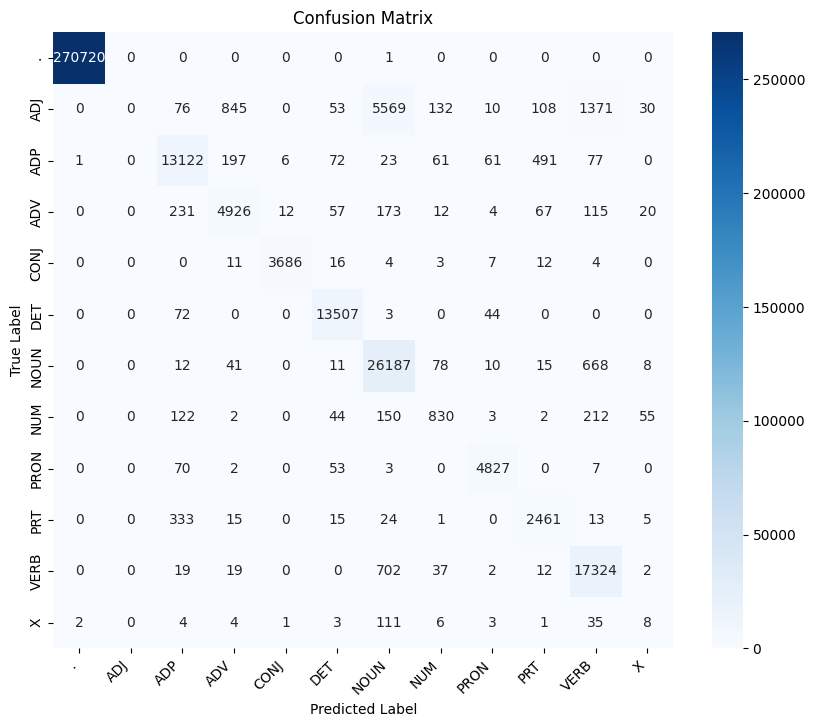

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(tag2idx)) + 0.5, labels=list(tag2idx.keys()), rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tag2idx)) + 0.5, labels=list(tag2idx.keys()))
plt.show()

In [32]:
print("Overall Metrics:")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1-score: {overall_f1:.2f}")
print(f"Overall Accuracy: {overall_accuracy:.2f}")

print("\nClass-Specific Metrics:")
print(classification_report(all_true_labels, all_predicted_labels, zero_division=0, target_names=list(tag2idx.keys()), labels=np.unique(all_true_labels)))

# Heatmap is already displayed by plt.show() in the previous step

Overall Metrics:
Overall Precision: 0.95
Overall Recall: 0.96
Overall F1-score: 0.96
Overall Accuracy: 0.96

Class-Specific Metrics:
              precision    recall  f1-score   support

           .       1.00      1.00      1.00    270721
         ADJ       0.00      0.00      0.00      8194
         ADP       0.93      0.93      0.93     14111
         ADV       0.81      0.88      0.84      5617
        CONJ       0.99      0.98      0.99      3743
         DET       0.98      0.99      0.98     13626
        NOUN       0.79      0.97      0.87     27030
         NUM       0.72      0.58      0.64      1420
        PRON       0.97      0.97      0.97      4962
         PRT       0.78      0.86      0.82      2867
        VERB       0.87      0.96      0.91     18117
           X       0.06      0.04      0.05       178

    accuracy                           0.96    370586
   macro avg       0.74      0.76      0.75    370586
weighted avg       0.95      0.96      0.96    370586

